In [1]:

import argparse
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abcclassify.abcclassify as abcc
import csv
import os.path
from sklearn import tree
import copy

np.random.seed(123)




In [2]:
participant = abcc.videotracking(framerange=(10530, 15611))
participant.addtrackingdata("/home/zzalsdme/IDInteraction/paper/results/OpenFace/P01_front.openface")
groundtruth = abcc.loadExternalGroundTruth("/home/zzalsdme/IDInteraction/paper/results/Groundtruth/P01_attention.csv", \
                                           participant)
# All the potential training frames
trainingframes = participant.frames
np.random.shuffle(trainingframes)
participant.setClassificationMethod("random")
n_splits=100


randparticipant = copy.deepcopy(participant)
randtrainingframes = trainingframes[:]

Loading tracking data from: /home/zzalsdme/IDInteraction/paper/results/OpenFace/P01_front.openface
OpenFace input detected


We want to explore different approaches to training the classifier.  We've already looked at sequential and random, and shown that random classification leads to much better performance.  

Rob suggested looking at areas that had poor performance, and focussing on these.  If we've got ground truth we *know* where has poor performance. Normally though we'll need to use cross validation to estimate the performance of the classifier


We want a window size such that the cross-validation scores are resonably stable.



In [3]:

def trainRegion(participant, groundtruth):
    """Apply the groundtruth data to a participant"""
    for index,row in groundtruth.iterrows():
        #print "setting classification for" + str(index) + ":" + str(row["state"])
        participant.setClassification(index, row["state"], testunset = True)
        

def calcWindowedAccuracy(participant, windowsize, advancesize):
    """Test the xval accuracy of overlapping windows within the object"""
    firstframe = min(participant.frames)
    lastframe = max(participant.frames)

    windowstarts = range(firstframe, lastframe , advancesize)
    windowends = [x + windowsize for x in windowstarts]
    
    # Set windowends to the smaller of their value or the end of the region
    windowends = [min(x,max(participant.frames)) for x in windowends]
    
       
    means=[]
    stds = []
    numclassframes = []
    numframes = []
    
    for (start,end) in zip(windowstarts,windowends):
        
        thispart = participant.split((start, end))
        try: 
            thispartvtc = abcc.videotrackingclassifier(thispart)
            shufsplitscore = thispartvtc.getShuffleSplitScore(n_splits=n_splits)
        except ValueError:
            shufsplitscore = np.array([np.NaN])
        means.append(shufsplitscore.mean())
        stds.append(shufsplitscore.std())
        numclassframes.append(len(thispart.getClassifiedFrames()))
        numframes.append(len(thispart.frames))
        
    
    results = pd.DataFrame.from_items([("startframe", windowstarts),
                                       ("endframe", windowends),
                                  ("mean", means),
                                  ("std", stds),
                                  ("numclassframes", numclassframes),
                                  ("numframes", numframes)])
    
    return results

def plotaccuracy(p1, p2):
    # Figure modified from
    # https://matplotlib.org/examples/pylab_examples/scatter_hist.html

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    
    rect_main = [left, bottom, width, height]
    rect_cframes = [left, bottom_h, width, 0.2]


    # start with a rectangular Figure
    plt.figure(1) #, figsize=(8, 8))

    axMain = plt.axes(rect_main)
    axCframes = plt.axes(rect_cframes)
    if min(p1.frames) != min(p2.frames) or \
        max(p1.frames) != max(p2.frames):
            raise IndexError("Frame ranges must match for both methods")
            
            
    # Calculate results for both methods 
    batchresults = calcWindowedAccuracy(p1, windowsize, advancesize)
    randbatchresults = calcWindowedAccuracy(p2, windowsize, advancesize)
    
    xlimit = (min(p1.frames), max(p1.frames))
    axMain.set_xlim(xlimit)
    axMain.set_ylim((0.6,1.0))
    axCframes.set_xlim(xlimit)
    axMain.plot(batchresults["startframe"], batchresults["mean"], color="blue")
    axMain.plot(randbatchresults["startframe"], randbatchresults["mean"], color="green")

    cframes = list(p1.getClassifiedFrames().index)
    axCframes.scatter(cframes, [1] * len(cframes), s=.1, color="blue")
    rcframes = list(p2.getClassifiedFrames().index)
    axCframes.scatter(rcframes, [1.1] * len(rcframes), s=1, color="green", alpha=0.8)

    plt.show()




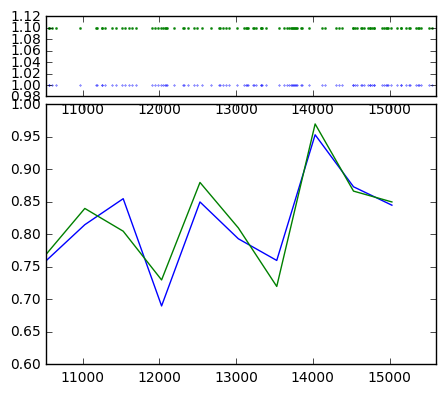

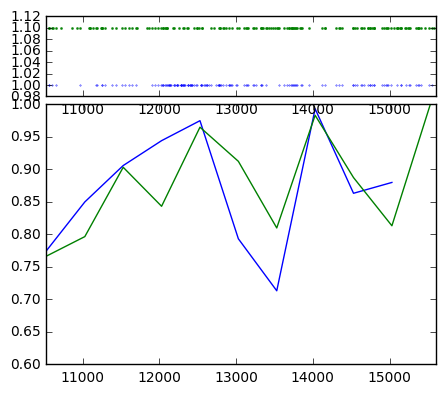

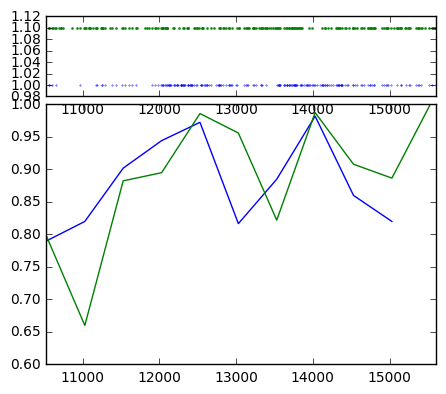

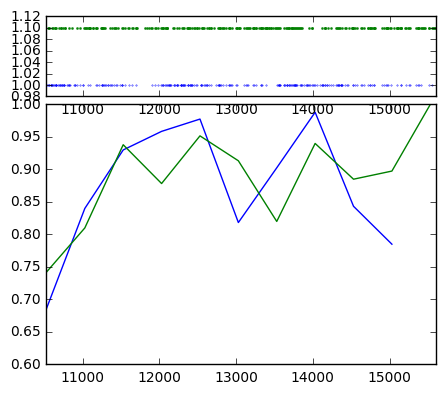

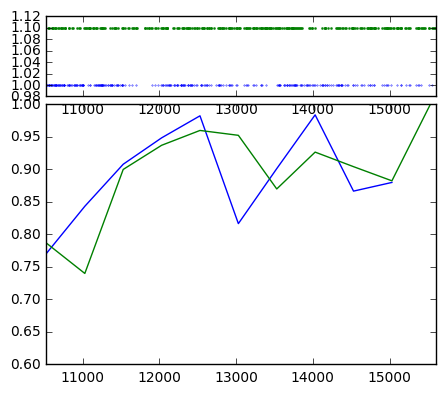

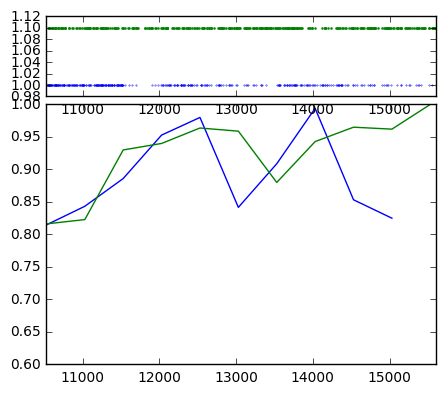

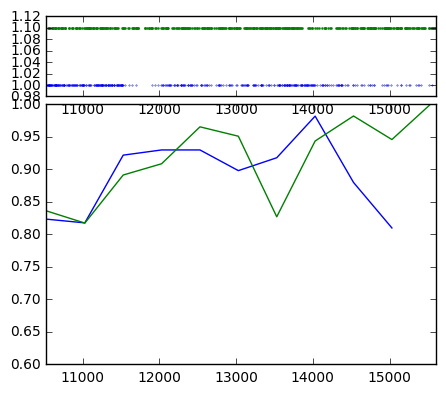

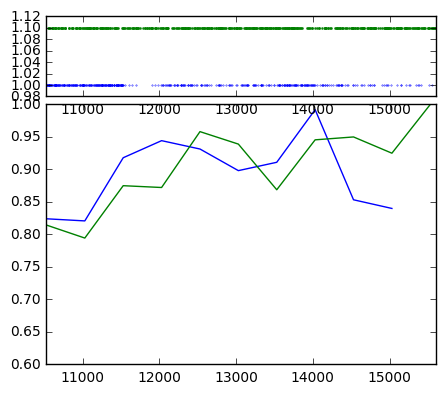

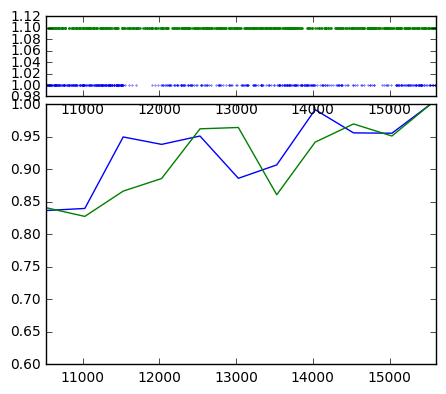

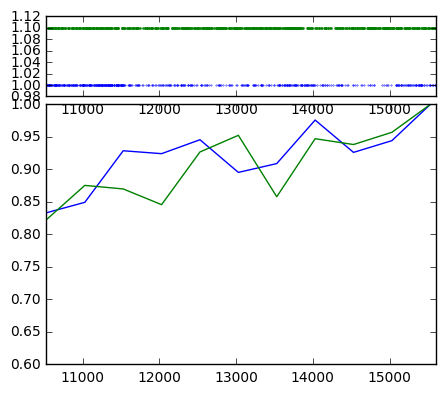

In [4]:
batchsize = 50
initialbatchsize = 2*batchsize
windowsize = 1000 # Number of (total - classified and unclassified) frames in each window
advancesize = 500  # The amount to advance each window by
# overlap between adjacent windows will be windowsize - advancesize


# Perform initial training 
trainRegion(participant, groundtruth.loc[trainingframes[:initialbatchsize]])

trainRegion(randparticipant, groundtruth.loc[randtrainingframes[:initialbatchsize]])
# Remove training frames used
randtrainingframes = randtrainingframes[initialbatchsize:]

results = pd.DataFrame(columns=["startframe", "classifiedframes", "mean", "std"])    
for i in range(0,10):
    plotaccuracy(participant, randparticipant)
    batchresults = calcWindowedAccuracy(participant, windowsize, advancesize)
    #print results
    missingwindows = sum(np.isnan(batchresults["mean"]))

    # Find the minimum accuracy startframe
    # TODO - handle tiebreaks - pick at random
    minstartframe = batchresults["startframe"].iloc[np.nanargmin(batchresults["mean"])]
    minendframe = batchresults["endframe"].iloc[np.nanargmin(batchresults["mean"])]
    
    # Get frames we to classify in this range
    trainrange = range(minstartframe, minendframe)
    if max(trainrange) > max(participant.gettrackableframes()):
        raise IndexError("Warning - training range extends beyond trackable region")
    
    # Remove frames we've already classified from the range of interest
    trainingframes = list(set(trainrange) - \
                      set(participant.getClassifiedFrames().index))
    if len(trainingframes) < batchsize:
        print "Warning - classifying all frames at " + str(minstartframe)
    # Randomise and select the appropriate number of frames for the 
    # targetted training
    np.random.shuffle(trainingframes)
    trainingframes = trainingframes[:batchsize]
    traindata = groundtruth.loc[trainingframes]
    trainRegion(participant, traindata)

    vtc = abcc.videotrackingclassifier(participant)
    shufsplitscore = vtc.getShuffleSplitScore(n_splits=n_splits)
        
    # And train the same number of frames at random
    randbatch = randtrainingframes[:len(trainingframes)]
    randtrainingframes = randtrainingframes[len(trainingframes):]
    trainRegion(randparticipant, groundtruth.loc[randbatch])
    rvtc = abcc.videotrackingclassifier(randparticipant)
    rshufsplitscore = rvtc.getShuffleSplitScore(n_splits=n_splits)
    
    if vtc.vto.numClassifiedFrames() != rvtc.vto.numClassifiedFrames():
        raise ValueError("Number of classified frames is out of sync")
    
    results = results.append({"startframe":minstartframe, 
                   "classifiedframes":vtc.vto.numClassifiedFrames(),
                   "mean":shufsplitscore.mean(),
                   "std": shufsplitscore.std(),
                   "randmean": rshufsplitscore.mean(),
                   "randstd" : rshufsplitscore.std(),
                   "batchsize": len(trainingframes)
                    }, ignore_index=True)
 
    


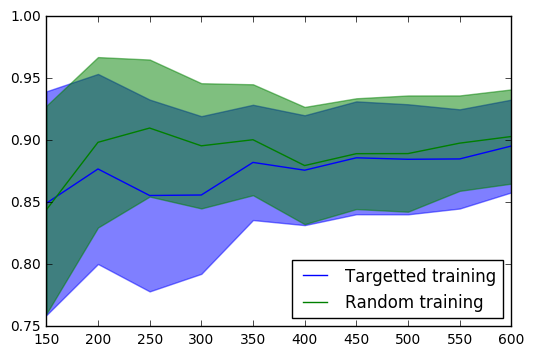

In [5]:
plt.fill_between(results["classifiedframes"], \
            results["mean"] - results["std"], results["mean"] + results["std"], \
                 alpha = 0.5, color="blue")

plt.fill_between(results["classifiedframes"], results["randmean"] - results["randstd"], \
                 results["randmean"] + results["randstd"], alpha = 0.5, color="green")

plt.plot(results["classifiedframes"], results["mean"], color="blue", label="Targetted training")
plt.plot(results["classifiedframes"], results["randmean"], color="green", label="Random training")
plt.legend(loc="lower right")
plt.show()

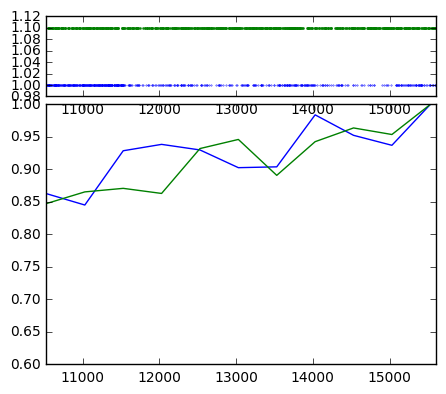

In [6]:


plotaccuracy(participant, randparticipant)


In [7]:
# Look at the accuracy when evaluating using the remaining ground truth
print "Targeted training external accuracy:"
print vtc.getAccuracy(groundtruth.loc[participant.getUnclassifiedFrames().index])
print "Random training external accuracy"
print rvtc.getAccuracy(groundtruth.loc[randparticipant.getUnclassifiedFrames().index])

Targeted training external accuracy:
0.898013836197
Random training external accuracy
0.885962954698


It appears that there is little difference in performance between the targetted and randomised training approaches, if we only train areas of poor performance.

Thoughts:
* Should the targetted approach be semi-stochastic?  I.e. target some additional training to weaker areas, and some at random; reduce the imbalance in density of classified frames.
* How much can we trust the results of the cross validation; typically a noisy measure.  Might bootstrap resampling be better?
* Should we include frame number in the tracking data? Currently assuming one tree works for the whole experiment part



